# Enunciado: Una noche en el casino
En un casino un jugador dispone de 30 fichas y decide jugar una noche a la ruleta.

La ruleta estándar contiene 37 ranuras, numeradas del 0 al 36. Entre los números del 1 al 10 y del 19 al 28, los números pares van en rojo y los impares en negro. Entre los números del 11 al 18 y del 29 al 36, los números pares van en negro y los impares en rojo. El 0 es verde.

Las probabilidades de pago vienen determinadas por la posibilidad de que la bola en aterrice en la ranura seleccionada. Sin embargo, las probabilidades solamente tienen en cuenta las 36 ranuras negras y rojas numeradas y no la ranura verde del
0.Por ejemplo, si apuestas a un solo número tienes una posibilidad entre 37 (1/37) de acertar, y 36 posibilidades de 37 (36/37) de no acertar. Sin embargo, la cuota paga a 35:1, no a 36:1. La ranura del 0 es lo que se denomina “margen de la casa” (house edge), es decir el dinero que el casino espera recibir.

El jugador puede realizar las siguientes apuestas, con los premios correspondientes:
* Pagos 1:1. Los pagos 1:1 son apuestas que te ofrecen una devolución de dinero igualada. Por ejemplo, si apuestas una ficha y aciertas ganas 1 ficha más la ficha apostada. Los tres pagos más comunes 1:1 son los de a favor del rojo, del negro, de par/impar o a favor de un número alto o bajo (1-18 o 19-36).
* Pagos 2:1. Apostar a una serie de doce números (docena). Véanse en el tablero los tres espacios de apuesta para las seis docenas por las que se puede apostar (por filas y por columnas).
* Pagos 5:1. Apostar en series de seis números, colocando las fichas en el lateral de la mesa entre dos filas, significa que estas apostando a los tres números de ambas filas.
* Pagos 8:1. Apostar en una serie de cuatro números, colocando las fichas en el medio de cuatro números.
* Pagos 11:1. Apostar en una fila de tres números, colocando las fichas en el lateral de la tabla junto a una fila.
* Pagos 17:1. Apostar a un par de números, vertical u horizontal, colocando la ficha entre los dos números elegidos.
*  Pagos 35:1. Para ganar un pago 35:1, tendrás que apostar a un solo número.

El jugador siempre va a apostar una ficha y se retira cuando se queda sin fichas o cuando alcanza las 150.

Se estima que el número máximo de partidas que se pueden jugar en una noche es de 50.

Partiendo del planteamiento del problema anterior se deberán resolver las siguientes cuestiones: 
1. Si decide apostar al azar (de forma equiprobable en entre los distintos tipos de apuestas):
    
    a)  ¿Qué proporción de noches a lo largo de un mes se ha retirado por quedarse sin dinero?
    
    b) ¿Cuál es el número de fichas con las que ha finalizado las noches de ese mes y cómo se distribuye (representar el histograma)?
    
    c) ¿Cuál es el número medio de partidas jugadas antes de retirarse por quedarse sin dinero?
    
    
2.  Si analizamos el problema a largo plazo, jugando partidas indefinidamente, y empezando con 30 fichas ¿cuál es la probabilidad de que me quede sin dinero? ¿y la de que termine con 150 fichas?


3.  ¿Con qué probabilidad debería jugar a cada una de las partidas para que el beneficio medio de cada noche sea máximo? Utilícese la metaheurística recocido simulado.


## 0.  Pasos previos

### Cargar librerías y funciones necesarias

In [22]:
import transition_matrix as tm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
print("Se han cargado todas las librerias necesarias")

Se han cargado todas las librerias necesarias


In [2]:
gambling_random = np.random
gambling_random.seed(42)

In [3]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

### Modelización del enunciado
En esta sección vamos a modelar los diferentes elementos que componen nuestro problema. 
* Juego de la ruleta: probabilidades de ganar cierta apuesta de la ruleta y beneficio obtenido

In [4]:
bets = [(1, float(18 / 37)), # Pagos 1:1.
        (2, float(12 / 37)), # Pagos 2:1.
        (5, float(6 / 37)),  # Pagos 5:1.
        (8, float(4 / 37)),  # Pagos 8:1
        (11, float(3 / 37)), # Pagos 11:1.
        (17, float(2 / 37)), # Pagos 17:1.
        (35, float(1 / 37))] # Pagos 35:1.

* Probabilidades de realizar las apuestar anteriormente realizadas, son probabilidades equiprobables. A continuación el algoritmio SA se encargará de buscar el vector de probabilidades óptimo. 

In [5]:
p_bets_eq = [float(1/len(bets))]*len(bets)

* Límite de partidas y fichas: 

In [42]:
LEAVE_WITH_MIN = 0
LEAVE_WITH_MAX = 150
NUM_GAMES = 500
INITIAL_CHIPS = 10

### Construir la matriz de transición

Una cadena es un proceso en tiempo discreto en el que una variable aleatoria $X_n$ va cambiando con el paso del tiempo. Las
cadenas de Markov tienen la propiedad de que la probabilidad de que $X_n = j$ sólo depende
del estado inmediatamente anterior del sistema: $X_n−1$. Cuando en una cadena dichas
probabilidades no dependen del tiempo en que se considere, $n$, $P(X_n = j | X-{n−1} = i)$

A continuación vamos a construir la cadena de Markov haciendo uso de la función `create_transition_matrix` que nosotros mismos hemos implementado. Esta mátriz se construye básandonos en el enunicado anteriormente comentado y en las propiedades de la cadena de Markov: 
$$
T = [p_{ij}] = \begin{bmatrix}
p_{1,1} & p_{1,2}  & \cdots  & p_{1,m} \\ 
p_{2,1} & p_{2,2} & \cdots & p_{2,m}\\ 
\vdots & \vdots & \ddots &  \cdots \\ 
p_{m,1} & p_{m,2}  & \cdots  &  p_{m,m}
\end{bmatrix}
$$

donde $p_{ij}$ es la probabilidad de ir del estado $i$ al $j$. En nuestro caso, un estado representa la cantidad de fichas que nuestro jugador tiene en ese momento. La probabilidad $p_{ij}$ es la probabilidad con la que el jugador pasa de tener $i$ a $j$ fichas. Cada una de las probabilidades se calcula de la siguiente manera: 

$P(probabilidad \  de\  realizar\  esta \ apuesta | probabilidad \ de\  ganar\  la\  apuesta)$

La matriz de transición se construye sabiendo los estados (en este caso el valor máximo y mínimo de fichas que puede alcanzar el jugador), las probabilidades de realizar las apuestas y las probabilidades de ganar la apuesta realizada. 

In [43]:
matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, p_bets_eq)

Vamos a visualizar la matriz creada por medio de la libreria pandas y añadiendo un vector de filas y columnas que representan los estados del problema, es decir, las fichas que tiene el jugador en cada momento. 

In [44]:
df = pd.DataFrame(matrix)
df

,0,1,2,3,4,5,6,7,8,9,...,175,176,177,178,179,180,181,182,183,184
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.822394,0.000000,0.069498,0.046332,0.000000,0.000000,0.023166,0.000000,0.000000,0.015444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.822394,0.000000,0.069498,0.046332,0.000000,0.000000,0.023166,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.822394,0.000000,0.069498,0.046332,0.000000,0.000000,0.023166,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.822394,0.000000,0.069498,0.046332,0.000000,0.000000,0.023166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Ejercicio 1: 
###       a)  ¿Qué proporción de noches a lo largo de un mes se ha retirado por quedarse sin dinero?


In [45]:
def simulate_game(state, matrix, gambling_random):
    return gambling_random.choice(range(len(matrix[state])), p=matrix[state])

In [46]:
def simulate_night(matrix, gambling_random, NUM_GAMES, state):
    chips = []
    chips.append(state)
    for i in range(NUM_GAMES-1):
        chips.append(simulate_game(chips[-1], matrix, gambling_random))
    return chips
        

In [47]:
chips = [simulate_night(matrix, gambling_random,200, INITIAL_CHIPS) for i in range(NUM_GAMES)]

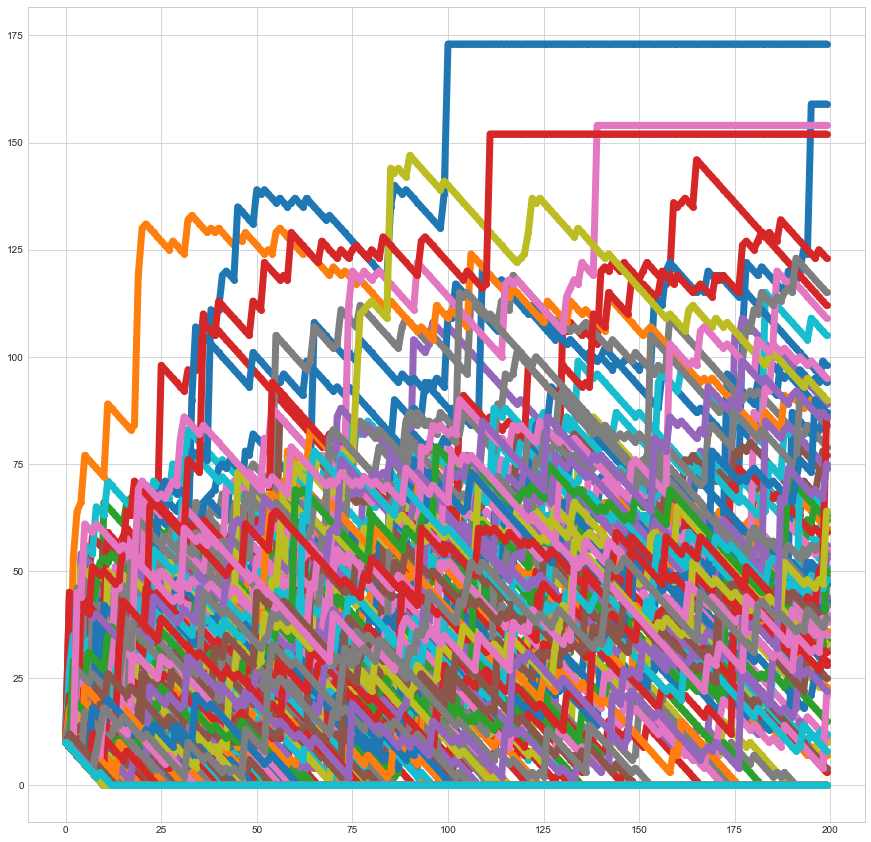

In [48]:
x = range(len(chips[0]))
plt.figure(figsize=(15, 15))
for i,y in enumerate(chips):
    plt.plot(x, y,linewidth=7.0,  marker='o')

In [49]:
final_chips = [x[-1] for x in chips]
df = pd.DataFrame(final_chips)
df.describe()

,0
count,500.000000
mean,9.854000
std,26.293257
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,173.000000


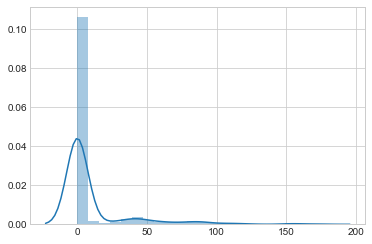

In [50]:
sns.distplot(df);

##### La siguiente celda muestra los imports necesarios para poder ejecutar el agoritmo

In [32]:
import graficos as gf
from random import randrange
import algoritmos as al
import numpy as np



Se han cargado todas las librerias necesarias


### Seleccionar las características del algoritmo

#### Seleccionar la función a optimizar, definir el intervalo.

In [2]:
NUM_NOCHES = 50
ALGORITMO = al.recocido_simulado_memory
VECINDAD = al.vecindad
VALOR_INICIAL = al.inicializador_aleatorio(INTERVALO)
P_ACEPTACION = al.probabilidad_aceptacion

### Ejecución del algoritmo

In [3]:
x, y, valores_x, valores_y, valores_t = ALGORITMO(FUNCION, VECINDAD, VALOR_INICIAL, P_ACEPTACION, NUM_ITERACIONES, 2)

Nueva mejor solucion, x = 26.000085777974846 - f(x) = 0.024878914429471904
Nueva mejor solucion, x = 26.000091678332318 - f(x) = 0.02487873571854043
Nueva mejor solucion, x = 26.001082846523936 - f(x) = 0.02484870392750834
Nueva mejor solucion, x = 26.001386849902083 - f(x) = 0.024839488376398027
Nueva mejor solucion, x = 26.009630179034772 - f(x) = 0.024588810356052235
Nueva mejor solucion, x = 26.017855583539223 - f(x) = 0.024337170848112405
Nueva mejor solucion, x = 26.01787149520036 - f(x) = 0.02433668261638922
Nueva mejor solucion, x = 26.022044065283186 - f(x) = 0.024208460257755433
Nueva mejor solucion, x = 26.027408906192885 - f(x) = 0.024043041132268246
Nueva mejor solucion, x = 26.02797693317605 - f(x) = 0.024025490028059347
Nueva mejor solucion, x = 26.0314982172733 - f(x) = 0.023916532460777833
Nueva mejor solucion, x = 26.03776715134389 - f(x) = 0.023721895580788226
Nueva mejor solucion, x = 26.03967852133062 - f(x) = 0.023662384526772568
Nueva mejor solucion, x = 26.04066

### Visualización de los resultados del algoritmo

Solución x: 2.7985378915408017
Calidad de la solución x, f(x):-0.3365084130390758


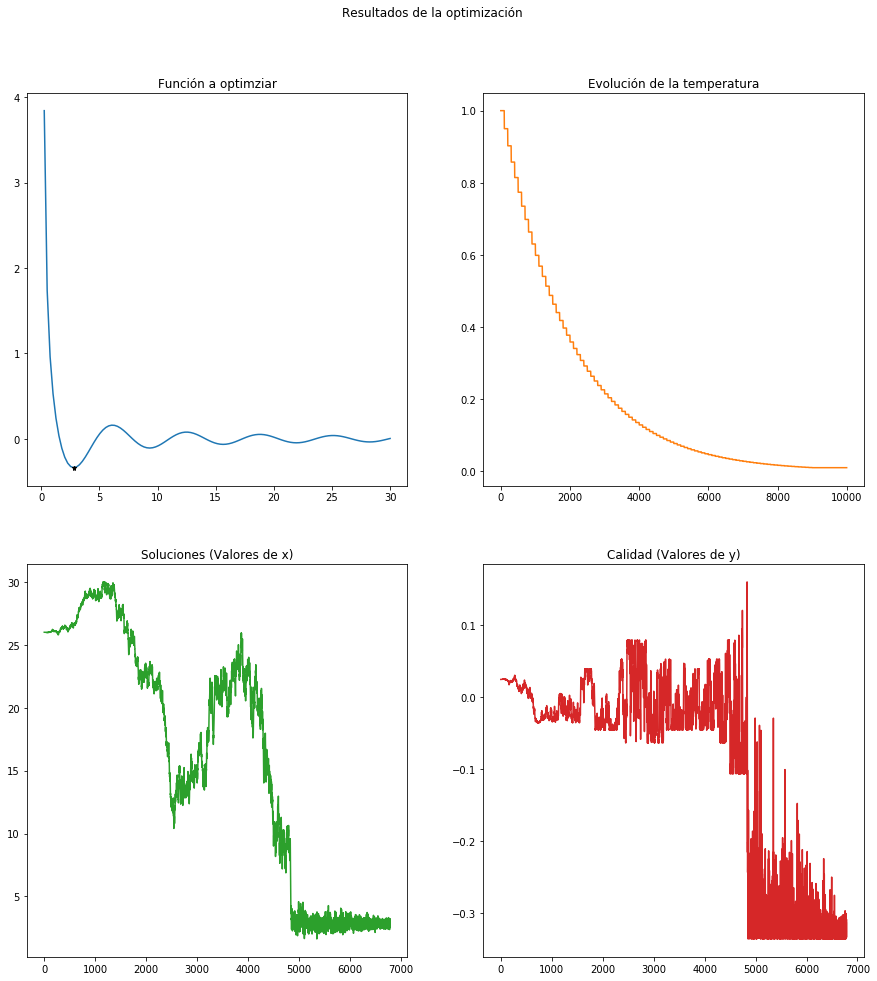

In [4]:
gf.plot_results(FUNCION, INTERVALO, valores_x, valores_y, valores_t, x, y)

In [18]:
R2 = random
R2.seed(200)

In [19]:
R1.random()

0.04560930208539393

In [20]:
R2.random()

0.20344697486239927